In [1]:
import numpy as np
import os
import scipy.stats
import matplotlib.pyplot as plt
import random
import time
import pickle as pkl
import scipy.stats as st
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import phase_analysis
import phase_processor
import PGanalysis

In [2]:
# set the target directory for figure 1 phase experiment data 
expt_list = os.listdir(r'Z:\robin\Paper\phase_coding_manuscript\data\fig1_supplement\bulb\phase_stats')
target_dir = r'Z:\robin\Paper\phase_coding_manuscript\data\fig1_supplement\bulb\phase_stats'

In [3]:
# load the phase experiment data dictionaries 
all_phase_expts = []
for expt in expt_list:
    load_path = os.path.join(target_dir, expt)
    phase_expt = np.load(load_path,allow_pickle = True)[0]
    all_phase_expts.append(phase_expt)

In [4]:
# concatenate this set of fields using the dict_key_concatenator. We will use these concatenated fields in later analyses. 
dict_keys = ['Kruskal_pval_thresh', 'Mann_Whitney_responsive_cell_bins', 'all_stim_resp_pref_phase', 'all_stim_time_to_50', 'stimulation_phase_preference']
concat_dict = {}
for key in dict_keys:
    concat_dict[key] = phase_analysis.dict_key_concatenator(all_phase_expts, key)

In [5]:
stimulation_phase_preference = concat_dict['stimulation_phase_preference']
all_stim_rise_times = concat_dict['all_stim_time_to_50']
all_stim_resp_pref_phase = concat_dict['all_stim_resp_pref_phase']

In [6]:
# calculation proportion of cells significantly activated by each spot
all_spot_activated = []
for expt in all_phase_expts: 
    # for each cell, for each spot, get the number of bins in which the cell is significantly activated.
    stim_activated_thresh = np.sum(expt['Mann_Whitney_responsive_cell_bins']['activated'],1)
    n_stim = expt['Kruskal_pval_thresh'].shape[0]
    for stim in range(n_stim):
        if stim>0:
            # for each spot, if there is a bin in which the cell is significantly activated, count the cell as activated by that spot.
            activated_count = len(np.where((stim_activated_thresh[stim,:]>0))[0])
            all_count = len(stim_activated_thresh[stim,:])
            # calculate the proportion of cells that are significantly activated by each spot. 
            all_spot_activated.append((activated_count/all_count)*100)

In [7]:
all_spot_tuned_total = []
all_spot_tuned_responsive = []
for expt in all_phase_expts: 
    # for each cell, for each spot, get the number of bins in which the cell is significantly activated.
    stim_activated_thresh = np.sum(expt['Mann_Whitney_responsive_cell_bins']['activated'],1)
    n_stim = expt['Kruskal_pval_thresh'].shape[0]
    for stim in range(n_stim):
        if stim>0:
            # count cells that are both significantly activated and significantly tuned. 
            activated_tuned_count = len(np.where((expt['Kruskal_pval_thresh'][stim,:]>0)&(stim_activated_thresh[stim,:]>0))[0])
            all_count = len((stim_activated_thresh[stim,:]>0))
            all_activated = len(np.where(stim_activated_thresh[stim,:]>0)[0])
            # get the percentage of total cells that are both activated and tuned
            all_spot_tuned_total.append((activated_tuned_count/all_count)*100)
            # get the percentage of significantly activated cells that are tuned. 
            if all_activated>0:
                all_spot_tuned_responsive.append((activated_tuned_count/all_activated)*100)

meta NOT subset; don't know how to subset; dropped


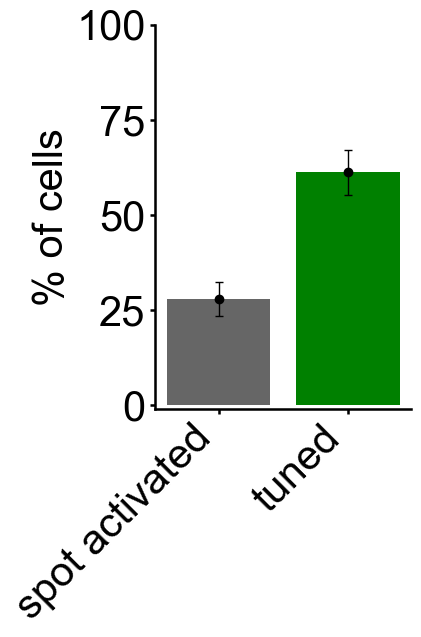

In [12]:
# plot percentage of significantly activated cells (mann whitney U p < .0025) that are tuned (kruskal-wallis p<.01)
color = [[.4,.4,.4],'g']
plt.bar([0,1], [np.mean(all_spot_activated), np.mean(all_spot_tuned_responsive)], color = color)
plt.ylim(-1,100)
plt.yticks([0,25,50,75,100])
plt.ylabel('% of cells')
CI_total = np.mean(all_spot_activated) -st.t.interval(alpha=0.95, df=len(all_spot_activated)-1, loc=np.mean(all_spot_activated), scale=st.sem(all_spot_activated))[0]
CI_responsive = np.mean(all_spot_tuned_responsive) -st.t.interval(alpha=0.95, df=len(all_spot_tuned_responsive)-1, loc=np.mean(all_spot_tuned_responsive), scale=st.sem(all_spot_tuned_responsive))[0]
plt.xticks([0,1], labels = ['spot activated', 'tuned'], rotation = 45, ha = 'right')
plt.errorbar([0,1], [np.mean(all_spot_activated), np.mean(all_spot_tuned_responsive)], yerr = [CI_total, CI_responsive], fmt = 'o', capsize = 3, elinewidth = 1, capthick = 1, linewidth = .5, color= 'k')
PGanalysis.axis_fixer(ratio = 1.5, size = 30)
plt.savefig(r'S:\All_Staff\robin\Paper\phase_coding_manuscript\figures\fig5\percent_activated_tuned.pdf', bbox_inches = 'tight')

In [13]:
print('Mean proportion of cells significantly activated by a given spot in at least one bin = ' + str(np.mean(all_spot_activated)))
CI = st.t.interval(alpha=0.95, df=len(all_spot_activated)-1, loc=np.mean(all_spot_activated), scale=st.sem(all_spot_activated))
print('95% confidence interval = ' + str(np.mean(all_spot_activated) - CI[0]))

Mean proportion of cells significantly activated by a given spot in at least one bin = 27.796527301468608
95% confidence interval = 4.453714456805585


In [14]:
print('Mean percentage of all responsive cells that are tuned = ' + str(np.mean(all_spot_tuned_responsive)))
CI = st.t.interval(alpha=0.95, df=len(all_spot_tuned_responsive)-1, loc=np.mean(all_spot_tuned_responsive), scale=st.sem(all_spot_tuned_responsive)) 
print('95% confidence interval = ' + str(np.mean(all_spot_tuned_responsive) - CI[0]))

Mean percentage of all responsive cells that are tuned = 61.15839888531746
95% confidence interval = 5.878094436194793


In [15]:
# Load the tuning curves for all cell-stim pairs
expt_list_tuning = os.listdir(r'Z:\robin\Paper\phase_coding_manuscript\data\fig1_supplement\bulb\phase_tuning')
target_dir_tuning = r'Z:\robin\Paper\phase_coding_manuscript\data\fig1_supplement\bulb\phase_tuning'

all_phase_tuning = []
for expt in expt_list_tuning:
    load_path = os.path.join(target_dir_tuning, expt)
    phase_tuning = np.load(load_path,allow_pickle = True)[0]
    all_phase_tuning.append(phase_tuning)

# concatenate tuning curves for all cells across experiments 
all_phase_tuning_concat = all_phase_tuning[0]
for tun in all_phase_tuning[1:]:
    all_phase_tuning_concat = np.concatenate((all_phase_tuning_concat, tun), axis = 2)

In [16]:
# get the tuning curves for all significantly activating spots for all cells 
n_cells = all_phase_tuning_concat.shape[2]
all_responsive_spot_tuning_curves = []
for cell in range(n_cells):
    # pull out spots that significantly activate the cell (a non-nan stimulation phase preference)
    responsive_spots = np.where(~np.isnan(stimulation_phase_preference[:,cell]))[0]
    if len(responsive_spots)>0:
        responsive_spot_tuning_curves = all_phase_tuning_concat[responsive_spots,:,cell]
        all_responsive_spot_tuning_curves.append(responsive_spot_tuning_curves)

In [17]:
# flatten the list so we have an n_cell_spot_pairs x n_bins matrix
all_responsive_spot_tuning_curves_flat = np.array([spot for cell in all_responsive_spot_tuning_curves for spot in cell])
# normalize the tuning curves
all_stim_tuning_ravel_norm = all_responsive_spot_tuning_curves_flat/np.max(all_responsive_spot_tuning_curves_flat,1)[:,None]

meta NOT subset; don't know how to subset; dropped


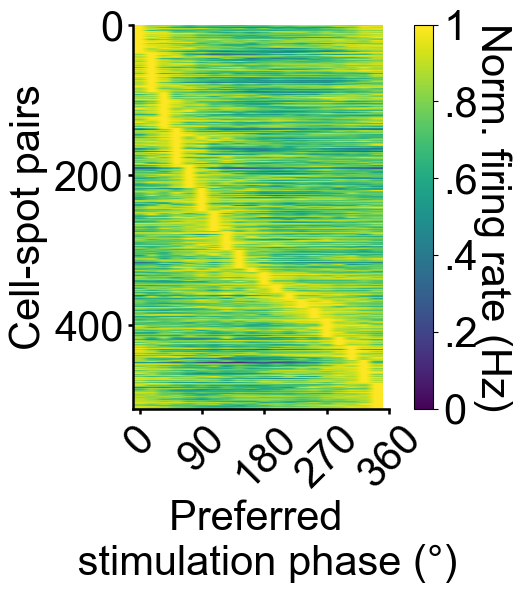

In [18]:
# plot the sorted tuning curves 
idx = np.argsort(np.argmax(all_stim_tuning_ravel_norm,1))
fig = plt.imshow(all_stim_tuning_ravel_norm[idx],aspect = 'auto')
plt.xticks(np.arange(0,25,5), labels = [str(x) for x in np.arange(0,450,90)], rotation = 45)
plt.clim(0,1)
plt.xlabel('Preferred \n stimulation phase (°)')
plt.ylabel('Cell-spot pairs')
ax = plt.gca()
cbar = plt.colorbar()
cbar.solids.set_edgecolor("face")
cbar.ax.set_yticks([0,.2,.4,.6,.8,1])
cbar.ax.set_yticklabels(['0', '.2','.4','.6','.8','1'])
cbar.ax.set_ylabel('Norm. firing rate (Hz)', rotation = 270)
cbar.ax.get_yaxis().labelpad = 25
PGanalysis.axis_fixer(ratio = 1.5, size = 30)
plt.savefig(r'S:\All_Staff\robin\Paper\phase_coding_manuscript\figures\fig5\all_sig_cell_spot_tuning.pdf', bbox_inches = 'tight')

In [19]:
all_stim_tuning_ravel_norm_PCx = np.load('all_stim_tuning_ravel_norm_PCx.npy', allow_pickle = True)

meta NOT subset; don't know how to subset; dropped


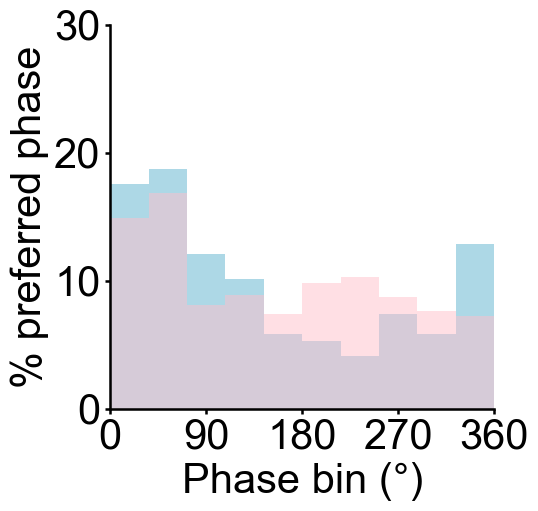

In [20]:
hist_pref = np.histogram(np.argmax(all_stim_tuning_ravel_norm,1))
hist_pref_PCx = np.histogram(np.argmax(all_stim_tuning_ravel_norm_PCx,1))
plt.bar(np.arange(18,360,36), (hist_pref[0]/np.sum(hist_pref[0]))*100, width = 36, color = 'lightblue')
plt.bar(np.arange(18,360,36), (hist_pref_PCx[0]/np.sum(hist_pref_PCx[0]))*100, width = 36, color = 'pink',alpha = .5)
plt.xlim(0,360)
plt.ylim(0,30)
plt.xticks([0,90,180,270,360])
plt.ylabel('% preferred phase')
plt.xlabel('Phase bin (°)')
PGanalysis.axis_fixer(ratio = 1, size = 30)
plt.savefig(r'S:\All_Staff\robin\Paper\phase_coding_manuscript\figures\fig5\tuning_hist.pdf', bbox_inches = 'tight')

In [21]:
# calculate the phase tuning index
ori_idx = np.empty((all_phase_tuning_concat.shape[0], all_phase_tuning_concat.shape[2]))
for cell in range(all_phase_tuning_concat.shape[2]):
    for stim in range(all_phase_tuning_concat.shape[0]):
        ori_idx[stim,cell] = (np.max(all_phase_tuning_concat[stim,:,cell])-np.min(all_phase_tuning_concat[stim,:,cell]))/(np.max(all_phase_tuning_concat[stim,:,cell]))

In [22]:
# get the phase tuning index only for significantly activated cell-spot pairs 
# also get the phase tuning index for responses to the blank stimulus 
# calculate the difference between the tuning index for each significantly activated cell-spot pair and the blank 
stimulation_phase_preference = concat_dict['stimulation_phase_preference']
ori_idx_all_responsive = []
ori_idx_all_diff = []
for cell in range(all_phase_tuning_concat.shape[2]):
    ori_idx_resp = ori_idx[np.where(~np.isnan(stimulation_phase_preference[:,cell]))[0],cell]
    ori_idx_blank = ori_idx[0,cell]
    if len(ori_idx_resp)>0:
        ori_idx_all_responsive.append(list(ori_idx_resp))
        ori_idx_all_diff.append(ori_idx_resp - ori_idx_blank)
ori_idx_all_responsive_OB = [cell for cells in ori_idx_all_responsive for cell in cells]
ori_idx_all_responsive_diff = [cell for cells in ori_idx_all_diff for cell in cells]

In [23]:
ori_idx_all_responsive_PCx = np.load('ori_index_PCx.npy', allow_pickle = True)

meta NOT subset; don't know how to subset; dropped


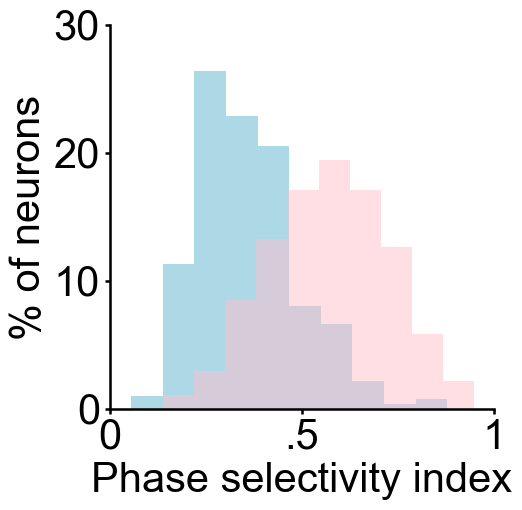

In [24]:
OB_ori = np.histogram(ori_idx_all_responsive_OB)
PCx_ori = np.histogram(ori_idx_all_responsive_PCx)
plt.bar(OB_ori[1][0:-1], (OB_ori[0]/np.sum(OB_ori[0]))*100, width = OB_ori[1][1]-OB_ori[1][0], color = 'lightblue')
plt.bar(PCx_ori[1][0:-1], (PCx_ori[0]/np.sum(PCx_ori[0]))*100, width = PCx_ori[1][1]-PCx_ori[1][0], color = 'pink', alpha = .5)
plt.ylim(0,30)
plt.xlim(0,1)
plt.ylabel('% of neurons')
plt.xlabel('Phase selectivity index')
plt.xticks([0,.5,1], labels = ['0','.5','1'])
PGanalysis.axis_fixer(ratio = 1, size =30)
plt.savefig(r'S:\All_Staff\robin\Paper\phase_coding_manuscript\figures\fig5\phase_selectivity_OB_PCx.pdf', bbox_inches = 'tight')

In [25]:
print('Mean ori index OB = ' + str(np.mean(ori_idx_all_responsive_OB)))
CI = st.t.interval(alpha=0.95, df=len(ori_idx_all_responsive_OB)-1, loc=np.mean(ori_idx_all_responsive_OB), scale=st.sem(ori_idx_all_responsive_OB))
print('95% confidence interval = ' + str(np.mean(ori_idx_all_responsive_OB) - CI[0]))

Mean ori index OB = 0.4008637267362659
95% confidence interval = 0.011374304007229497


In [26]:
print('Mean ori index PCx = ' + str(np.mean(ori_idx_all_responsive_PCx)))
CI = st.t.interval(alpha=0.95, df=len(ori_idx_all_responsive_PCx)-1, loc=np.mean(ori_idx_all_responsive_PCx), scale=st.sem(ori_idx_all_responsive_PCx))
print('95% confidence interval = ' + str(np.mean(ori_idx_all_responsive_PCx) - CI[0]))

Mean ori index PCx = 0.610956381303468
95% confidence interval = 0.010555277199374435


In [27]:
st.ttest_ind(ori_idx_all_responsive_OB, ori_idx_all_responsive_PCx)

Ttest_indResult(statistic=-25.596190720607012, pvalue=7.003144872833805e-118)

In [81]:
os.chdir(r'S:\All_Staff\robin\Paper\phase_coding_manuscript\final_data\fig5')
spontaneous_spiking_OB_control = np.load(r'spontaneous_spiking_OB_control.npy', allow_pickle = True)[0]

In [83]:
all_percent_locked = []
for expt in spontaneous_spiking_OB_control['all_spontaneously_locked']:
    all_percent_locked.append(np.mean(expt))

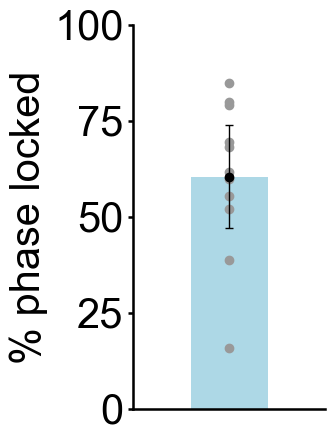

In [84]:
color = [[.4,.4,.4]]
plt.bar([0], [np.mean(all_percent_locked)*100],color = 'lightblue')
plt.ylim(0,100)
plt.xlim(-1,1)
plt.yticks([0,25,50,75,100])
plt.ylabel('% phase locked')

plt.xticks([])

plt.plot(np.zeros(len(all_percent_locked)), np.array(all_percent_locked)*100,'o', color = [.6,.6,.6])

phase_locked_err = np.mean(all_percent_locked) -st.t.interval(alpha=0.95, df=len(all_percent_locked)-1, loc=np.mean(all_percent_locked), scale=st.sem(all_percent_locked))[0]

plt.errorbar(0, np.mean(np.array(all_percent_locked)*100), yerr = phase_locked_err*100, fmt = 'o', capsize = 3, elinewidth = 1, capthick = 1, linewidth = .5, color= 'k')

PGanalysis.axis_fixer(ratio =2, size = 30)

In [85]:
all_percent_locked_spikes_flat = np.array([spike for spikes in spontaneous_spiking_OB_control['all_percent_locked_spikes'] for spike in spikes])

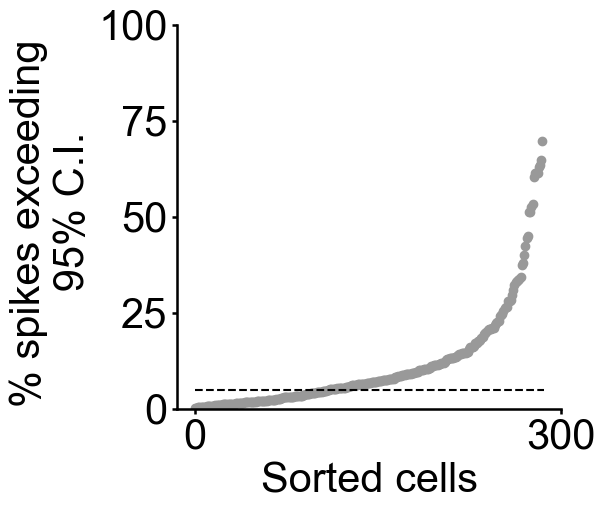

In [87]:
plt.plot(np.sort(all_percent_locked_spikes_flat),'o', color = [.6,.6,.6])
plt.plot([0, len(all_percent_locked_spikes_flat)],[5,5],'k--')
plt.ylim(0,100)
plt.xticks([0,300])
plt.ylabel('% spikes exceeding \n 95% C.I.')
plt.xlabel('Sorted cells')
PGanalysis.axis_fixer(ratio = 1, size = 30)

In [89]:
all_phase_hist_flat = np.array([hist for hists in spontaneous_spiking_OB_control['all_phase_hist'] for hist in hists])
all_CI_lower_flat = np.array([hist for hists in spontaneous_spiking_OB_control['all_lower_CI'] for hist in hists])
all_CI_upper_flat = np.array([hist for hists in spontaneous_spiking_OB_control['all_upper_CI'] for hist in hists])

In [90]:
bins = np.arange(0,np.radians(360)+np.radians(9), np.radians(9))

In [93]:
all_spontaneously_locked_flat = np.array([curve for expt in spontaneous_spiking_OB_control['all_spontaneously_locked'] for curve in expt])
significantly_locked = np.where(all_spontaneously_locked_flat == 1)[0]

In [94]:
all_spontaneous_bin_rate_flat = np.array([curve for expt in spontaneous_spiking_OB_control['all_spontaneous_bin_rate'] for curve in expt])
all_spontaneous_bin_rate_flat_norm = all_spontaneous_bin_rate_flat/np.max(all_spontaneous_bin_rate_flat,1)[:,None]

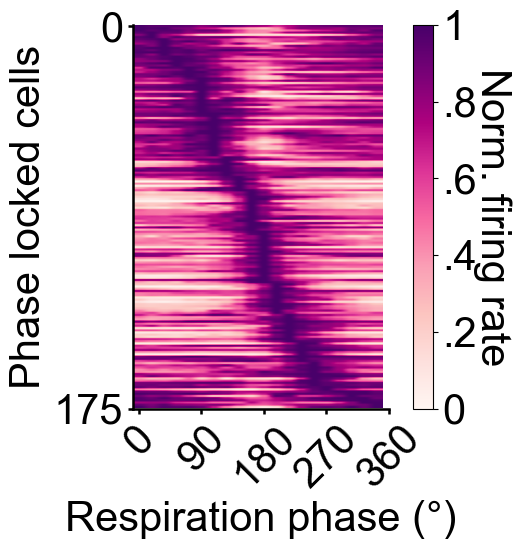

In [95]:
idx = np.argsort(np.argmax(all_spontaneous_bin_rate_flat_norm[significantly_locked,:],1))
plt.imshow(all_spontaneous_bin_rate_flat_norm[significantly_locked][idx,:], cmap = 'RdPu')
plt.clim(0,1)
plt.xticks(np.arange(0,25,5), labels = ['0','90','180','270', '360'], rotation = 45)
plt.yticks([0, len(significantly_locked)])
plt.ylabel('Phase locked cells')
plt.xlabel('Respiration phase (°)')
ax = plt.gca()
cbar = plt.colorbar()
cbar.solids.set_edgecolor("face")
cbar.ax.set_yticks(np.arange(0,1.2,.2))
cbar.ax.set_yticklabels(['0', '.2','.4','.6','.8','1'])
cbar.ax.set_ylabel('Norm. firing rate', rotation = 270)
cbar.ax.get_yaxis().labelpad = 25
PGanalysis.axis_fixer(ratio = 1.5, size = 30)

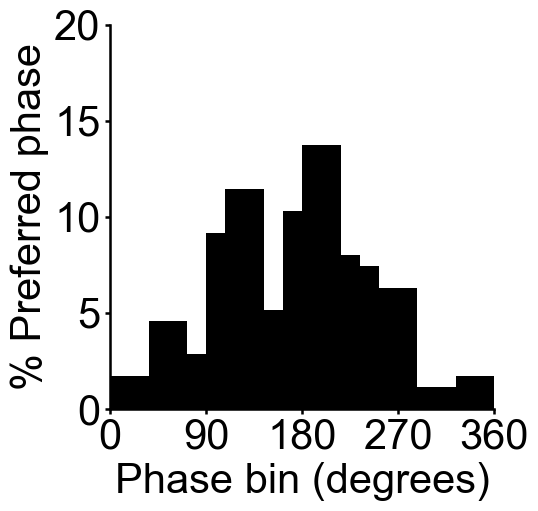

In [103]:
phases = np.arange(0,378,18)
phases_10bins = np.arange(0,378,18)
pref_phases = phases[np.argmax(all_spontaneous_bin_rate_flat_norm[significantly_locked,:],1)]
hist_pref = np.histogram(pref_phases, bins = phases_10bins)
plt.bar(np.arange(0,360,18), (hist_pref[0]/np.sum(hist_pref[0]))*100, width = 36, color = 'k', align = 'edge')
plt.xlim(0,360)
plt.ylim(0,20)
plt.xticks([0,90,180,270,360])
plt.ylabel('% Preferred phase')
plt.xlabel('Phase bin (degrees)')
PGanalysis.axis_fixer(ratio = 1, size = 30)

In [106]:
all_phase_tuning_concat.shape

(11, 20, 286)

In [89]:
os.chdir(r'C:\Users\rmb55\most_updated_pattern_stim\pattern_stim_analysis\paper\pattern_stim_code\pattern-stimulation\figure_generation\figure5')
iter_bulb_decoding_accuracy = np.load('iter_bulb_decoding_accuracy.npy', allow_pickle = True)
iter_PCx_decoding_accuracy = np.load('iter_PCx_decoding_accuracy.npy', allow_pickle = True)
iter_PCx_decoding_accuracy_1cell = np.load('iter_PCx_decoding_accuracy_1cell.npy', allow_pickle = True)
iter_bulb_decoding_accuracy_1cell = np.load('iter_bulb_decoding_accuracy_1cell.npy', allow_pickle = True)

In [69]:
iter_PCx_decoding_accuracy_1cell.shape

(50, 1)

In [90]:
iter_PCx_decoding_accuracy = np.concatenate((iter_PCx_decoding_accuracy_1cell, iter_PCx_decoding_accuracy), axis = 1)
iter_bulb_decoding_accuracy = np.concatenate((iter_bulb_decoding_accuracy_1cell, iter_bulb_decoding_accuracy), axis = 1)

In [71]:
iter_PCx_decoding_accuracy.shape

(50, 26)

In [39]:
iter_PCx_decoding_accuracy.shape

(50, 25)

In [86]:
n_cells_PCx

array([  1,  20,  40,  60,  80, 100, 120, 140, 160, 180, 200, 220, 240,
       260, 280, 300, 320, 340, 360, 380, 400, 420, 440, 460, 480, 500,
       520])

meta NOT subset; don't know how to subset; dropped


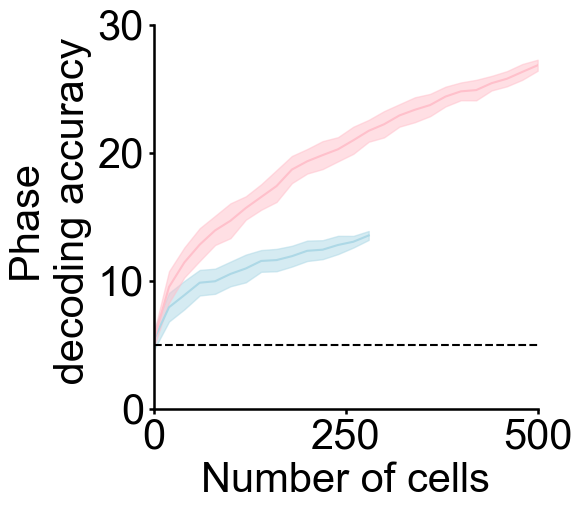

In [103]:
n_cells_OB = np.arange(20,all_phase_tuning_concat.shape[2],20)
n_cells_OB = np.insert(n_cells_OB, 0, 1)
plt.plot(n_cells_OB, np.mean(iter_bulb_decoding_accuracy,0), 'lightblue')
n_cells_PCx = np.arange(20,(iter_PCx_decoding_accuracy.shape[1]-1)*20+20,20)
n_cells_PCx = np.insert(n_cells_PCx, 0, 1)
plt.plot(n_cells_PCx, np.mean(iter_PCx_decoding_accuracy,0), 'pink')

OB_CI = []
for sample in range(len(n_cells_OB)):
    data = iter_bulb_decoding_accuracy[:,sample]
    t = st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=st.sem(data))
    OB_CI.append(np.mean(data)-t[0])
    
PCx_CI = []
for sample in range(len(n_cells_PCx)):
    data = iter_PCx_decoding_accuracy[:,sample]
    t = st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=st.sem(data))
    PCx_CI.append(np.mean(data)-t[0])
    
ax = plt.gca()
#ax.fill_between(n_cells, np.mean(iter_bulb_decoding_accuracy,0) - OB_CI, np.mean(iter_bulb_decoding_accuracy,0) + OB_CI, color = [.8,.8,.8])
ax.fill_between(n_cells_OB, np.mean(iter_bulb_decoding_accuracy,0) - np.std(iter_bulb_decoding_accuracy,0), np.mean(iter_bulb_decoding_accuracy,0) + np.std(iter_bulb_decoding_accuracy,0), color = 'lightblue', alpha = .5)
ax.fill_between(n_cells_PCx, np.mean(iter_PCx_decoding_accuracy,0) - np.std(iter_PCx_decoding_accuracy,0), np.mean(iter_PCx_decoding_accuracy,0) + np.std(iter_PCx_decoding_accuracy,0), color = 'pink', alpha = .5)

plt.plot([0,500],[.05,.05],'k--')

plt.ylim(0,.3)

plt.yticks([0,.1,.2,.3], labels = ['0','10','20','30'])
plt.xticks([0,250,500])
plt.xlim(0,500)

plt.xlabel('Number of cells')
plt.ylabel('Phase \n decoding accuracy')

PGanalysis.axis_fixer(ratio = 1)
PGanalysis.axis_fixer(ratio = 1, size = 30)
plt.savefig(r'S:\All_Staff\robin\Paper\phase_coding_manuscript\figures\fig5\phase_decoding_accuracy_OB_PCx.pdf', bbox_inches = 'tight')

In [49]:
# set the target directory for trial-by-trial spike counts over the 300ms response period for each experiment
expt_list = os.listdir(r'Z:\robin\Paper\phase_coding_manuscript\data\fig1_supplement\bulb\population_analysis_data')
target_dir = r'Z:\robin\Paper\phase_coding_manuscript\data\fig1_supplement\bulb\population_analysis_data'

In [15]:
''' bin spike counts for each spot type into phases'''
def bin_spike_counts_by_phase(trial_type_spike_counts, bin_indices_all, max_trial = []):
    trial_type_phase_binned_spike_counts = []
    stim_phase_binned_spike_counts = []
    for stim_n, stim in enumerate(bin_indices_all):
        stim_phase_binned_counts = []
        for idx in np.unique(stim):
            if max_trial:
                stim_phase_binned_counts.append(trial_type_spike_counts[:,stim_n, np.where(stim == idx)[0][0:max_trial]])
            else: 
                stim_phase_binned_counts.append(trial_type_spike_counts[:,stim_n, np.where(stim == idx)[0]])
        trial_type_phase_binned_spike_counts.append(stim_phase_binned_counts)
    return trial_type_phase_binned_spike_counts

In [16]:
# bin the spike counts by the phase of OB stimulation. For each phase bin, we will use the first 15 trials of stimulation. 
all_phase_expts = []
for expt in expt_list:
    load_path = os.path.join(target_dir, expt)
    phase_expt = np.load(load_path,allow_pickle = True)[0]
    binned_spike_counts = phase_analysis.bin_spike_counts_by_phase(phase_expt['trial_type_spike_counts'], phase_expt['bin_indices_all'], max_trial = 15)
    all_phase_expts.append(np.array(binned_spike_counts))

In [17]:
# set some useful parameters
n_spots = all_phase_expts[0].shape[0] # 11 spots (10 and 1 blank)
n_bins = all_phase_expts[0].shape[1] # 20 bins
n_trials = 15 # hard-coded, we will analyze the first 15 trials of each stimulation-phase for each spot

In [18]:
# concatenate cells across experiments for all spots (excluding the blank)
all_phase_expts_spot_cat = all_phase_expts[0][1:,:,:,:]
for expt in all_phase_expts[1:]:
    all_phase_expts_spot_cat = np.concatenate((all_phase_expts_spot_cat, expt[1:,:,:,:]), axis = 2)

In [19]:
train_data, labels = phase_analysis.generate_training_data_phase_decoder(all_phase_expts_spot_cat)

In [20]:
# Now, let's train an svm classifier using this data 
X_train = train_data
y_train = labels 
svm_clf = SVC(kernel = 'linear')

# train and test the classifier using 5-fold cross-validation
y_train_pred = cross_val_predict(svm_clf, X_train, y_train, cv = 5)
conf_mx = confusion_matrix(y_train, y_train_pred)

# to get the % accuracy, divide the matrix by the number of trials 
row_sums = conf_mx.sum(axis = 1, keepdims = True)
conf_mx_spots = conf_mx/row_sums

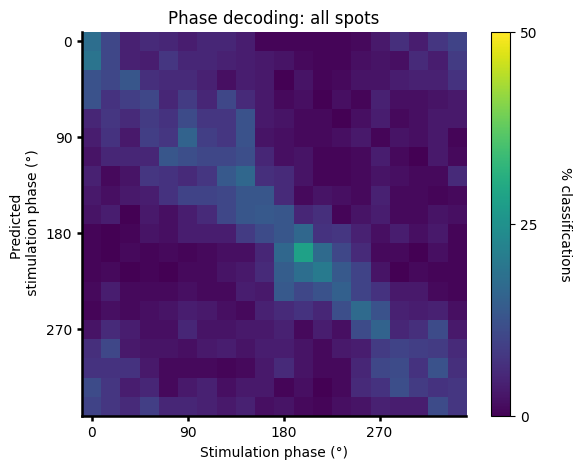

In [21]:
# plot the phase classification accuracy for spot stimulation
plt.imshow(conf_mx_spots)
plt.title('Phase decoding: all spots')
plt.xticks(np.arange(0,20,5), labels = [str(x) for x in np.arange(0,360,90)])
plt.yticks(np.arange(0,20,5), labels = [str(x) for x in np.arange(0,360,90)])
plt.ylabel('Predicted \n stimulation phase (°)')
plt.xlabel('Stimulation phase (°)')

plt.clim(0,.5)
ax = plt.gca()
cbar = plt.colorbar(ticks = [0,.25,.5])
cbar.solids.set_edgecolor("face")
cbar.ax.set_ylabel('% classifications', rotation = 270)
cbar.ax.get_yaxis().labelpad = 25
cbar.ax.set_yticklabels(['0','25','50'])
PGanalysis.axis_fixer(size = 20)

In [22]:
# Concatenate all of the cell responses in the blank condition (spot 0)
spot = 0
all_phase_expts_spot_cat_blank = all_phase_expts[0][spot,:,:,:]
for expt in all_phase_expts[1:]:
    all_phase_expts_spot_cat_blank = np.concatenate((all_phase_expts_spot_cat_blank, expt[spot,:,:,:]), axis = 1)
    
# rearrange and reshape the matrix, get phase labels for each trial
trial_type_phase_binned_spike_counts_move = np.moveaxis(all_phase_expts_spot_cat_blank, (0,1), (1,0))
spike_counts_reshaped, labels, stim_idxs = PGanalysis.spike_shaper_2d(trial_type_phase_binned_spike_counts_move)

# Train and test the classifier using 5-fold cross-validation
X_train = spike_counts_reshaped
y_train = labels 
svm_clf = SVC(kernel = 'linear')
y_train_pred = cross_val_predict(svm_clf, X_train, y_train, cv = 5)
conf_mx_blank = confusion_matrix(y_train, y_train_pred)

# divide by the number of trials in the corresponding class
row_sums_blank = conf_mx_blank.sum(axis = 1, keepdims = True)
conf_mx_blank = conf_mx_blank/row_sums_blank

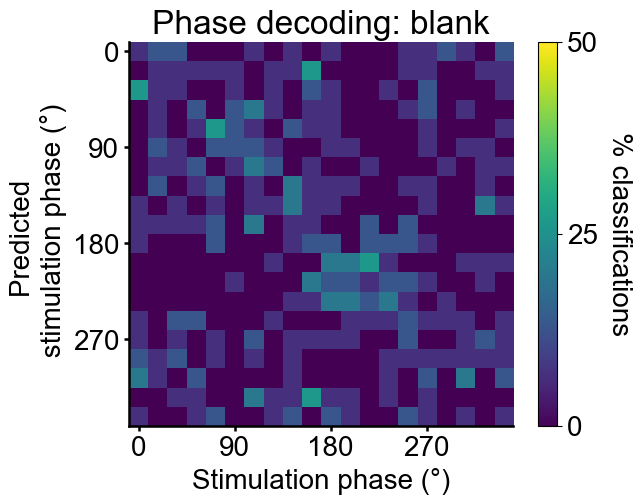

In [23]:
# plot the phase classification accuracy for blank trials
plt.imshow(conf_mx_blank)
plt.title('Phase decoding: blank')
plt.xticks(np.arange(0,20,5), labels = [str(x) for x in np.arange(0,360,90)])
plt.yticks(np.arange(0,20,5), labels = [str(x) for x in np.arange(0,360,90)])
plt.ylabel('Predicted \n stimulation phase (°)')
plt.xlabel('Stimulation phase (°)')

plt.clim(0,.5)
ax = plt.gca()
cbar = plt.colorbar(ticks = [0,.25,.5])
cbar.solids.set_edgecolor("face")
cbar.ax.set_ylabel('% classifications', rotation = 270)
cbar.ax.get_yaxis().labelpad = 25
cbar.ax.set_yticklabels(['0','25','50'])
PGanalysis.axis_fixer(size = 20)

In [24]:
# rearrange the axes so we end up with an n_bins x (n_spots x n_trials) x n_cells array. This gives us 150 trials per spot bin. 
all_phase_expts_spot_cat_arranged = np.moveaxis(all_phase_expts_spot_cat, (2,3), (3,2))
all_phase_expts_spot_cat_arranged = np.moveaxis(all_phase_expts_spot_cat_arranged, (0,1), (1,0))
all_phase_expts_spot_cat_reshaped = np.reshape(all_phase_expts_spot_cat_arranged,
                                               (all_phase_expts_spot_cat_arranged.shape[0],all_phase_expts_spot_cat_arranged.shape[1]*all_phase_expts_spot_cat_arranged.shape[2],all_phase_expts_spot_cat_arranged.shape[3]))

In [25]:
# reshape the training data in n_instances(150*20) x n_features(519). create a labels array with 150 trials per phase bin. 
train_data = np.reshape(all_phase_expts_spot_cat_reshaped, (all_phase_expts_spot_cat_reshaped.shape[0]*all_phase_expts_spot_cat_reshaped.shape[1],all_phase_expts_spot_cat_reshaped.shape[2]))
labels = np.repeat(np.arange(all_phase_expts_spot_cat_reshaped.shape[0]),all_phase_expts_spot_cat_reshaped.shape[1])

In [26]:
# Here, we will use the same training data and labels as in the initial phase classifier. 
groups = []
for bin_ in range(n_bins):
    groups.append(np.repeat(np.arange(n_spots-1),n_trials))
groups = np.array([group for bin_ in groups for group in bin_])

In [27]:
# We will use GroupKFold to assess generalization performance. This allows us to split the training data into a set of training groups and a held-out group. 
from sklearn.model_selection import GroupKFold

# We will split the data into 10 different groups
group_kfold = GroupKFold(n_splits=n_spots-1)

# Save the 10 matrices that will be generated
generalize_conf_mx = np.empty((n_spots-1, n_bins, n_bins))
for i, (train_index, test_index) in enumerate(group_kfold.split(train_data, labels, groups)):
    
    # define the train and test sets 
    X_train = train_data[train_index,:]
    X_test = train_data[test_index,:]
    y_train = labels[train_index]
    y_test = labels[test_index]
    
    # train the SVM
    svm_clf = SVC(kernel = 'linear')
    svm_clf.fit(X_train, y_train)
    y_pred = svm_clf.predict(X_test)
    conf_mx = confusion_matrix(y_test, y_pred)
    row_sums = conf_mx.sum(axis = 1, keepdims = True)
    conf_mx = conf_mx/row_sums
    
    # save the output 
    generalize_conf_mx[i,:,:] = conf_mx

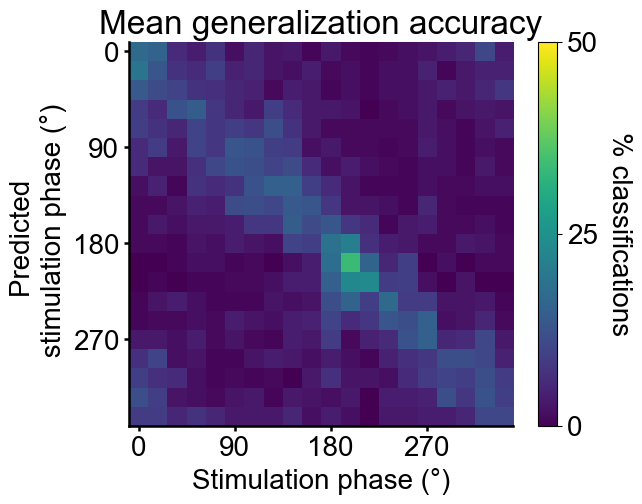

In [28]:
# plot the phase classification accuracy for spot stimulation
plt.imshow(np.mean(generalize_conf_mx,0))
plt.title('Mean generalization accuracy')
plt.xticks(np.arange(0,20,5), labels = [str(x) for x in np.arange(0,360,90)])
plt.yticks(np.arange(0,20,5), labels = [str(x) for x in np.arange(0,360,90)])
plt.ylabel('Predicted \n stimulation phase (°)')
plt.xlabel('Stimulation phase (°)')

plt.clim(0,.5)
ax = plt.gca()
cbar = plt.colorbar(ticks = [0,.25,.5])
cbar.solids.set_edgecolor("face")
cbar.ax.set_ylabel('% classifications', rotation = 270)
cbar.ax.get_yaxis().labelpad = 25
cbar.ax.set_yticklabels(['0','25','50'])
PGanalysis.axis_fixer(size = 20)

In [52]:
# Here, we will shift each row of the matrix so that the correct bin is centered.
# Do this for phase decoding and blank analyses
n_rolls = int(conf_mx.shape[0]/2)
t = np.arange((n_rolls),(n_rolls)*-1,-1)
rolled_mat_spots = np.zeros_like(conf_mx_spots)
rolled_mat_blank = np.zeros_like(conf_mx_blank)
for roll_n, roll in enumerate(t):
    rolled_mat_spots[roll_n,:] = np.roll(conf_mx_spots[roll_n,:],roll)
    rolled_mat_blank[roll_n,:] = np.roll(conf_mx_blank[roll_n,:],roll)

In [53]:
# Perform the same analysis for each iteration of the generalization decoding
t = np.arange((n_spots-1),(n_spots-1)*-1,-1)
generalization_rolled_mats = np.empty((len(generalize_conf_mx), generalize_conf_mx[0].shape[0]))
rolled_mat = np.zeros_like(generalize_conf_mx[0])
for conf_mx_n, conf_mx in enumerate(generalize_conf_mx):
    for roll_n, roll in enumerate(t):
        rolled_mat[roll_n,:] = np.roll(conf_mx[roll_n,:],roll)
    generalization_rolled_mats[conf_mx_n, :] = np.mean(rolled_mat,0)

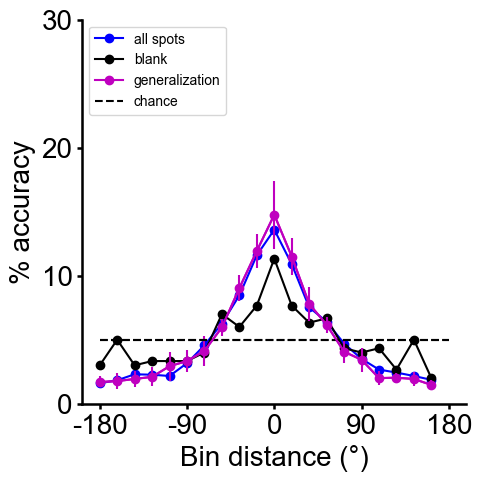

In [54]:
# plot classifier accuracy as a function of bin distance 
plt.plot(np.mean(rolled_mat_spots,0),'-bo', label = 'all spots')
plt.plot(np.mean(rolled_mat_blank,0),'-ko', label = 'blank')
plt.ylim(0,.3)
plt.ylabel('% accuracy')
plt.yticks([0,.1,.2,.3], labels = ['0','10','20','30'])
plt.xticks(np.arange(0,25,5), labels = [-180,-90,0,90,180])
plt.xlabel('Bin distance (°)')
PGanalysis.axis_fixer(ratio = 1, size = 30)

plt.plot(np.mean(generalization_rolled_mats,0),'m-o',label = 'generalization')

CI = []
for bin_ in range(20):
    data = generalization_rolled_mats[:,bin_]
    t = st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=st.sem(data)) 
    CI.append(t[1]-np.mean(data))
plt.errorbar(np.arange(20),np.mean(generalization_rolled_mats, 0), yerr = CI, color = 'm')

plt.ylim(0,.3)
plt.plot([0,20],[1/20, 1/20], 'k--')
plt.ylabel('% accuracy')
plt.yticks([0,.1,.2,.3], labels = ['0','10','20','30'])
plt.xticks(np.arange(0,25,5), labels = [-180,-90,0,90,180])
plt.xlabel('Bin distance (°)')
plt.plot([0,20],[1/20, 1/20], 'k--', label = 'chance')
plt.legend(loc = 'upper left', fontsize = 10)
PGanalysis.axis_fixer(ratio = 1, size = 30)

In [ ]:
def decode_phase(n_cells):
    cells = random.sample(list(np.arange(0,train_data.shape[1])), sample_size)
    train_data_pseudopop = train_data[:,cells]
    
    # Now, let's train an svm classifier using this data 
    X_train = train_data_pseudopop
    y_train = labels 
    svm_clf = SVC(kernel = 'linear')

    # train and test the classifier using 5-fold cross-validation
    y_train_pred = cross_val_predict(svm_clf, X_train, y_train, cv = 5)
    conf_mx = confusion_matrix(y_train, y_train_pred)

    # to get the % accuracy, divide the matrix by the number of trials 
    row_sums = conf_mx.sum(axis = 1, keepdims = True)
    conf_mx_spots = conf_mx/row_sums
    pseudopop_accuracy = np.mean(np.diag(conf_mx_spots))
    return pseudopop_accuracy